In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display
import re

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

### Variáveis Globais

In [2]:
imgSize = 32
batchSize = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Funções Auxiliares

In [3]:
data_dir = pathlib.Path('gtsrb/train_images/')
classNames = np.array(os.listdir(data_dir))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Modelo CNN

In [4]:
def CNN(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), padding='same',
                     input_shape=(imgSize, imgSize, channels),
                     activation='relu'))                     
    model.add(Conv2D(64, (5, 5), activation='relu') ) 
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    model.add(Conv2D(64, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classCount, activation='softmax'))
    
    opt = Adam(lr=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

model = CNN(43, imgSize, 3)

### Divisão dos Datasets *Training* e *Validation* 

In [5]:
# Arrays para guardar Paths das imagens para cada Dataset
training = []
validation = []

# Diretoria Global a ambos os Datasets
path = 'gtsrb/train_images/'
dir = os.listdir(path)

pattern = '000[0-9]{2}_000(01|02|05|25|27)'

for namePath in dir:
    images = os.listdir(path + namePath)
    for i in images:
        if re.search(pattern, i):
            validation.append(path + namePath + '/' + i)
        elif re.search('[0-9]{5}_[0-9]{5}.png', i):
            training.append(path + namePath + '/' + i)

### Carregar Imagens Datasets *Training* e *Validation*

In [6]:
listDatasetTraining = tf.data.Dataset.list_files(training)
listDatasetValidation = tf.data.Dataset.list_files(validation)

datasetTraining = listDatasetTraining.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetTrainingLength = [i for i,_ in enumerate(datasetTraining)][-1] + 1

datasetValidation = listDatasetValidation.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetValidationLength = [i for i,_ in enumerate(datasetValidation)][-1] + 1

### Preparar Datasets Training e Validation

In [7]:
datasetTraining = datasetTraining.cache()
datasetTraining = datasetTraining.shuffle(buffer_size = datasetTrainingLength)
datasetTraining = datasetTraining.batch(batch_size=batchSize)
datasetTraining = datasetTraining.prefetch(buffer_size=AUTOTUNE)
datasetTraining = datasetTraining.repeat()

datasetValidation = datasetValidation.cache()
datasetValidation = datasetValidation.shuffle(buffer_size = datasetValidationLength)
datasetValidation = datasetValidation.batch(batch_size=batchSize)
datasetValidation = datasetValidation.prefetch(buffer_size=AUTOTUNE)
datasetValidation = datasetValidation.repeat()

### Carregar Imagens e Preparar Dataset *Test*

In [8]:
datasetTest = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")

datasetTest = datasetTest.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetTest = datasetTest.batch(batch_size=batchSize)

### Treino da CNN

In [9]:
history = model.fit(
    datasetTraining,
    steps_per_epoch = datasetTrainingLength/batchSize,
    epochs = 20,
    validation_data = datasetValidation,
    validation_steps = datasetValidationLength/batchSize
)

Train for 1021.0625 steps, validate for 204.21875 steps
Epoch 1/20
1022/1021 [==============================] - 17s 17ms/step - loss: 1.5252 - categorical_accuracy: 0.5577 - val_loss: 0.4708 - val_categorical_accuracy: 0.8800
Epoch 2/20
1022/1021 [==============================] - 11s 11ms/step - loss: 0.3170 - categorical_accuracy: 0.8995 - val_loss: 0.1409 - val_categorical_accuracy: 0.9590
Epoch 3/20
1022/1021 [==============================] - 11s 11ms/step - loss: 0.1715 - categorical_accuracy: 0.9446 - val_loss: 0.1039 - val_categorical_accuracy: 0.9688
Epoch 4/20
1022/1021 [==============================] - 11s 11ms/step - loss: 0.1264 - categorical_accuracy: 0.9598 - val_loss: 0.0908 - val_categorical_accuracy: 0.9772
Epoch 5/20
1022/1021 [==============================] - 11s 11ms/step - loss: 0.1027 - categorical_accuracy: 0.9669 - val_loss: 0.0614 - val_categorical_accuracy: 0.9827
Epoch 6/20
1022/1021 [==============================] - 11s 11ms/step - loss: 0.0829 - categor

### Plot the Training History

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


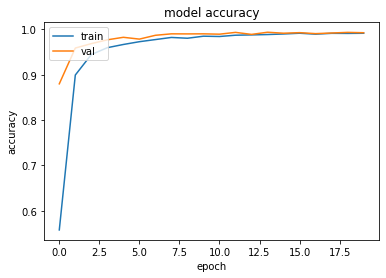

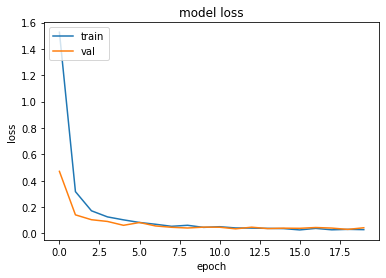

In [10]:
# Summarize History for Accuracy


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [11]:
model.evaluate(datasetTest)

395/395 [==============================] - 3s 7ms/step - loss: 0.3195 - categorical_accuracy: 0.9704


[0.31950190749792523, 0.97038794]